<a href="https://colab.research.google.com/github/vedashree2112/DL-flower-species-recognition/blob/main/dl_img_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('dl-img-recognition')
jovian.set_colab_id('1lqgQ6lwJMw5M8qVIHyafAPdu3rF-XsoJ')

     |████████████████████████████████| 68 kB 4.8 MB/s 


# dl-img-recognition

Use the "Run" button to execute the code.

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="dl-img-recognition")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/vedashree-gadekar/dl-img-recognition


'https://jovian.ai/vedashree-gadekar/dl-img-recognition'

# Identifying Flower Species Using Deep Learning and PyTorch


### TODO - introduction
The steps involved are as follows:
1. Pick a dataset
2. Download the dataset
3. Import the dataset using PyTorch
4. Prepare the dataset for training
5. Move the dataset to the GPU
6. Define a neural network
7. Train the model
8. Make predictions on sample images. 
Iterate on it with different networks and hyperparameters.

#### Downloading the flower recognition dataset from Kaggle: https://www.kaggle.com/alxmamaev/flowers-recognition


In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = "https://www.kaggle.com/alxmamaev/flowers-recognition"

### Context:
This dataset contains 4317 images of flowers.
The data collection is based on the data flicr, google images, yandex images.
### Content:
The pictures are divided into five classes: tulip, daisy, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions.

In [ ]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
   shutil.rmtree('./flowers-recognition')

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vedashreegadekar
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:04<00:00, 49.8MB/s]


### Import the dataset into PyTorch.
Use the `ImageFolder` class from `torchvision`.
Torchvision is a library for Computer Vision that goes hand in hand with PyTorch. It has utilities for efficient Image and Video transformations, some commonly used pre-trained models, and some datasets.
ImageFolder() organizes data in the following way: root/label/picture.png. Hence, the images are sorted into folders.


In [ ]:
data_dir = './flowers-recognition/flowers'

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['tulip', 'daisy', 'sunflower', 'rose', 'dandelion']

In [ ]:
pip install torchvision --quiet

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
# displaying length of the dataset
len(dataset)

4317

In [ ]:
# displaying classes
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
# printing length of each class
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

tulip : 984
daisy : 764
sunflower : 733
rose : 784
dandelion : 1052


In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F4CD0EEC890>, 0)

### Plotting an image from the dataset using `matplotlib`

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

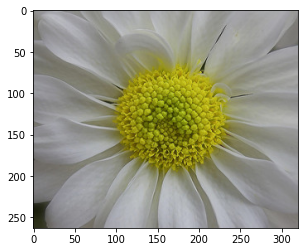

In [ ]:
img, label = dataset[0]
plt.imshow(img)

In [ ]:
# Applying transforms to the dataset through PyTorch to maintain uniformity
import torchvision.transforms as tt
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

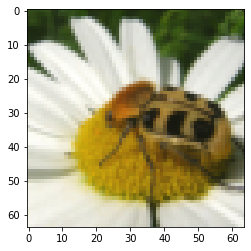

In [ ]:
# Developing image tensors
img, label = dataset[120]
plt.imshow(img.permute(1, 2, 0))

### Creating validation and training datasets

In [ ]:
val_pct = 0.1 # setting validation percentage
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size
train_size, val_size

(3886, 431)

In [ ]:
# Using random_split fn to split the dataset
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

Creating training and validation data loaders to load the data in batch size

In [ ]:
from torch.utils.data import DataLoader # defining DataLoader
batch_size = 128
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,  # number of subprocesses to use for data loading
                      pin_memory=True)# set'True'to speed up CPU to GPU memory copy operation
valid_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers=2, 
                      pin_memory=True) # shuffling of dataset not needed

Using `make_grid` method from torchvision to look at batches of images from the dataset. Each time the following code is run, we will get different batches as sampler shuffles indices before creating batches.


In [ ]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize =(12,6))
        ax.set_xticks([]); ax.set_yticks([]);
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

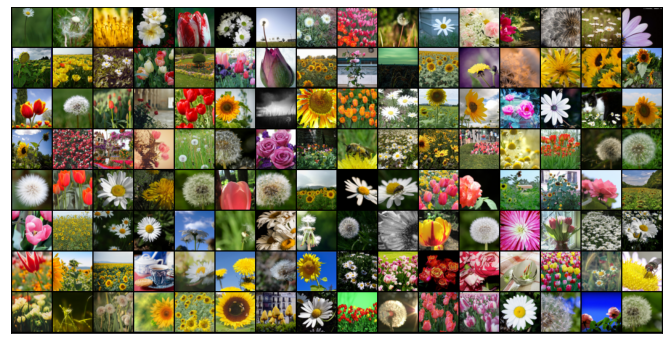

In [ ]:
#displaying a batch
show_batch(train_dl)

### GPU Utilities
Defining helper functions `get_default_device` and `to_device` and helper class `DeviceDataLoader` to move model and data to the GPU

In [ ]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available() 

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = dataset[0]                     

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
# wrapping dataloaders using DeviceDataLoader class
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Model and Training Utilities

In [ ]:
# single label classification is the problem type in the project
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):  # base class
    def training_step(self, batch):
        """calculate loss for a batch of training data"""
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        """calculate loss and accuracy for a batch of validation data"""
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
import torch
@torch.no_grad()
def evaluate(model, val_loader):  # Evaluates the model's performanceon the validation set
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()   # calculates gradients
            optimizer.step()  # performs gradient descent and updates the weights of the models
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32 
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32 
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32 
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16 
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
#checking the device of one of the parameters ie conv1 layer for instance
model.conv1[0].weight

Parameter containing:
tensor([[[[-0.1513,  0.0989, -0.0835],
          [ 0.0510, -0.1067,  0.1496],
          [-0.1516,  0.0747,  0.0304]],

         [[ 0.1272, -0.0507, -0.1286],
          [-0.1562, -0.0241,  0.0580],
          [-0.1316,  0.0920, -0.0091]],

         [[-0.1653,  0.1722,  0.1379],
          [-0.0726, -0.1064, -0.1158],
          [ 0.1192,  0.0581, -0.1750]]],


        [[[-0.1889, -0.0645,  0.1761],
          [-0.1350, -0.0476, -0.1378],
          [-0.1602, -0.0895, -0.0056]],

         [[-0.1111,  0.1665,  0.1191],
          [ 0.0465, -0.0962, -0.0284],
          [ 0.0128,  0.0564, -0.1565]],

         [[ 0.1471,  0.1165,  0.0615],
          [-0.0456,  0.1062, -0.1314],
          [-0.0853, -0.0123,  0.0975]]],


        [[[-0.1425, -0.1373, -0.1694],
          [-0.1872,  0.1232, -0.1395],
          [-0.0823,  0.0566, -0.1697]],

         [[ 0.0839, -0.1437, -0.0039],
          [-0.0957,  0.0663, -0.1025],
          [ 0.1662, -0.1635,  0.1115]],

         [[ 0.1651, -0

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

### Passing one batch of input tensor through the model

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


In [ ]:
# finding initial validation accuracy and loss
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.2488364279270172, 'val_loss': 1.6105320453643799}]

In [ ]:
# calling fit function
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4884, val_loss: 1.2734, val_acc: 0.4569
Epoch [1], train_loss: 0.9978, val_loss: 0.9464, val_acc: 0.6188
Epoch [2], train_loss: 0.8800, val_loss: 0.8466, val_acc: 0.6713
Epoch [3], train_loss: 0.7986, val_loss: 0.7286, val_acc: 0.7277
Epoch [4], train_loss: 0.7432, val_loss: 0.6820, val_acc: 0.7269


In [ ]:
# training for more time
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8522, val_loss: 0.8083, val_acc: 0.7073
Epoch [1], train_loss: 0.6741, val_loss: 0.7675, val_acc: 0.7269
Epoch [2], train_loss: 0.5977, val_loss: 0.5874, val_acc: 0.7771
Epoch [3], train_loss: 0.5440, val_loss: 0.8187, val_acc: 0.7185
Epoch [4], train_loss: 0.5075, val_loss: 0.6734, val_acc: 0.7702


In [ ]:
# training for even more time by reducing the learning rate
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3979, val_loss: 0.4795, val_acc: 0.8184
Epoch [1], train_loss: 0.3571, val_loss: 0.4819, val_acc: 0.8199
Epoch [2], train_loss: 0.3510, val_loss: 0.5161, val_acc: 0.8126
Epoch [3], train_loss: 0.3177, val_loss: 0.5059, val_acc: 0.7995
Epoch [4], train_loss: 0.3087, val_loss: 0.5830, val_acc: 0.7897


In [ ]:
# training for more time by using SGD(default so no need to mention)
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.2948, val_loss: 0.5078, val_acc: 0.8184
Epoch [1], train_loss: 0.2920, val_loss: 0.4996, val_acc: 0.8053
Epoch [2], train_loss: 0.2936, val_loss: 0.4986, val_acc: 0.8106
Epoch [3], train_loss: 0.2872, val_loss: 0.5110, val_acc: 0.8159
Epoch [4], train_loss: 0.2917, val_loss: 0.4993, val_acc: 0.8140


In [ ]:
# defining accuracy function
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

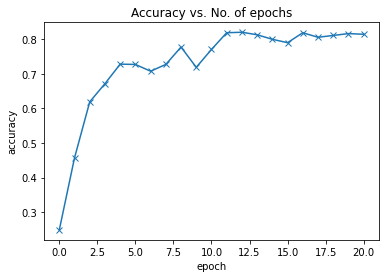

In [ ]:
# plotting accuracies
plot_accuracies(history)

In [ ]:
# defining losses function
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

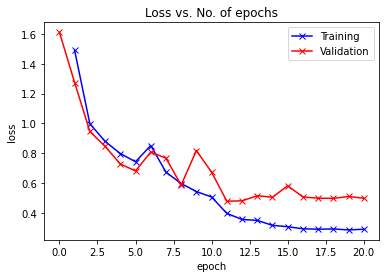

In [ ]:
# plotting losses
plot_losses(history)

## Record the Result

In [ ]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128,
                       arch = 'ResNet9',
                       epochs = [5, 5, 5, 5],
                       lrs = [0.001, 0.001, 1e-4, 1e-4],
                       opt = ['Adam', 'Adam', 'Adam', 'SGD'])
jovian.log_metrics(train_loss = history[-1]['train_loss'],
                   val_acc = history[-1]['val_acc'],
                   val_loss = history[-1]['val_loss'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [ ]:
jovian.commit(project = 'dl-img-recognition')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/vedashree-gadekar/dl-img-recognition


'https://jovian.ai/vedashree-gadekar/dl-img-recognition'

### Test with individual images

In [ ]:
# moves the img into gpu and converts the image into a batch of image
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
# predicting the class and displaying an image from valid_ds
def show_image_prediction(img, label):
    plt.imshow(img.permute(1, 2, 0))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: dandelion
Prediction: dandelion


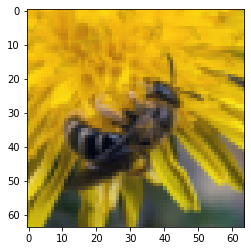

In [ ]:
show_image_prediction(*valid_ds[100])

Checking for more images from the dataset

Target: dandelion
Prediction: sunflower


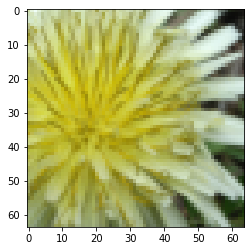

In [ ]:
show_image_prediction(*valid_ds[250])

Target: sunflower
Prediction: sunflower


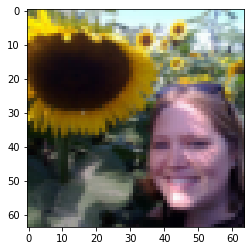

In [ ]:
show_image_prediction(*valid_ds[300])

Target: tulip
Prediction: tulip


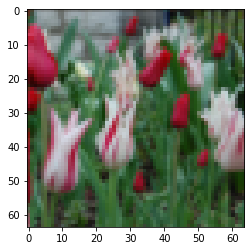

In [ ]:
show_image_prediction(*valid_ds[400])

Target: tulip
Prediction: dandelion


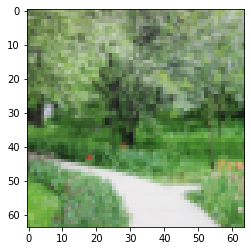

In [ ]:
show_image_prediction(*valid_ds[75])

Target: sunflower
Prediction: sunflower


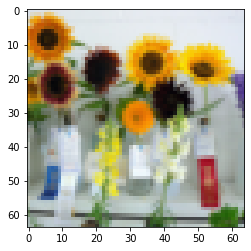

In [ ]:
show_image_prediction(*valid_ds[80])

Target: tulip
Prediction: tulip


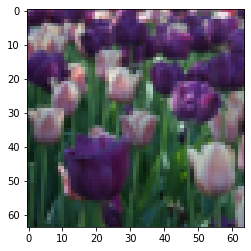

In [ ]:
show_image_prediction(*valid_ds[180])

Target: rose
Prediction: rose


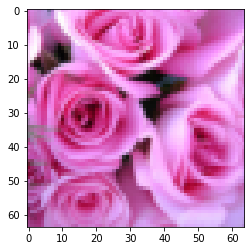

In [ ]:
show_image_prediction(*valid_ds[20])

Target: dandelion
Prediction: dandelion


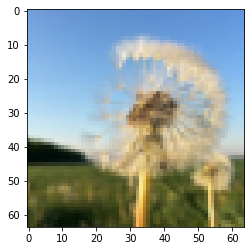

In [ ]:
show_image_prediction(*valid_ds[24])

Target: rose
Prediction: rose


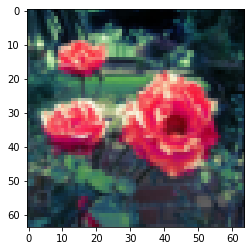

In [ ]:
show_image_prediction(*valid_ds[50])

In [ ]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')

In [ ]:
jovian.commit(project = 'dl-img-recognition',
              outputs = 'flowers-resnet9.pth')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/vedashree-gadekar/dl-img-recognition


'https://jovian.ai/vedashree-gadekar/dl-img-recognition'

### Transfer Learning
ResNet34 is a model that has been pretrained on the `ImageNet` dataset having 100,000+ images across 200 different classes

In [ ]:
from torchvision import models

class ResNet34(ImageClassificationBase): 
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

### Normalization

In [ ]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(img_size), 
                                           tt.RandomCrop(img_size),
                                           tt.ToTensor(),
                                           tt.Normalize(*imagenet_stats)]))

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

batch_size = 64

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,  
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers=2, 
                      pin_memory=True)


In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Applying fit one-cycle
Does not take fixed lr. Increases the lr for the first 30% of the cycle by a factor of 10 and then decreases it till 0 for the next part of the cycle.

In [ ]:
import torch
from tqdm.notebook import tqdm


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.2020801603794098, 'val_loss': 1.7161318063735962}]

In [ ]:
history += fit_one_cycle(8, 0.001, model, train_dl, valid_dl,
              weight_decay=0.01, grad_clip=0.1,
              opt_func=torch.optim.Adam)

  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.4918, val_loss: 0.6941, val_acc: 0.8478


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.5361, val_loss: 1.6520, val_acc: 0.4532


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6143, val_loss: 0.8982, val_acc: 0.6241


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5649, val_loss: 1.2971, val_acc: 0.5407


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5152, val_loss: 0.9587, val_acc: 0.6591


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.3784, val_loss: 0.5008, val_acc: 0.8121


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.2656, val_loss: 0.3479, val_acc: 0.8799


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1750, val_loss: 0.3294, val_acc: 0.8852


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

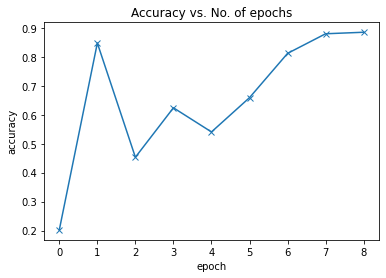

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

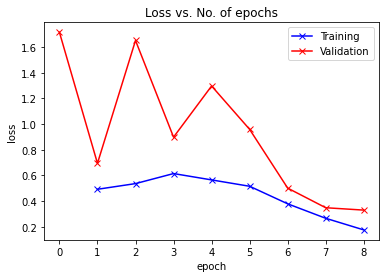

In [ ]:
plot_losses(history)

In [ ]:
import numpy as np

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

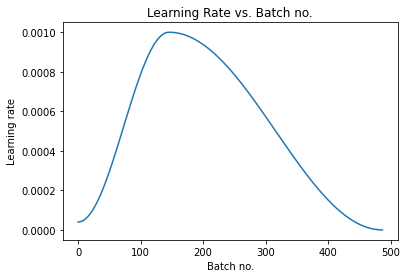

In [ ]:
plot_lrs(history)

### Denormalization

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: dandelion (1)
Predicted: dandelion


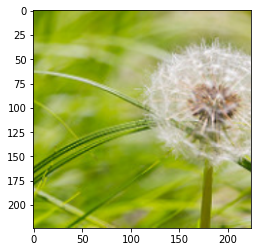

In [ ]:
img, label = valid_ds[0]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted:', pred)


Label: sunflower (3)
Predicted: sunflower


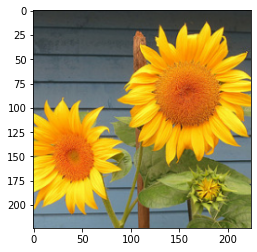

In [ ]:
img, label = valid_ds[120]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted:', pred)

Label: daisy (0)
Predicted: daisy


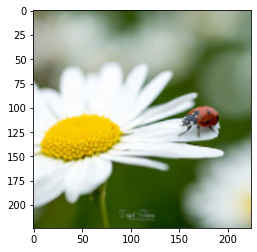

In [ ]:
img, label = valid_ds[300]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted:', pred)

Label: tulip (4)
Predicted: tulip


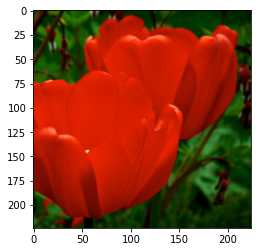

In [ ]:
img, label = valid_ds[50]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted:', pred)

Label: rose (2)
Predicted: rose


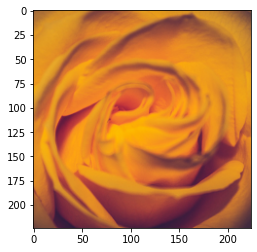

In [ ]:
img, label = valid_ds[180]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Predicted:', pred)

In [ ]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')

In [ ]:
jovian.commit(project = 'dl-img-recognition',
              outputs = 'flowers-resnet9.pth')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/vedashree-gadekar/dl-img-recognition


'https://jovian.ai/vedashree-gadekar/dl-img-recognition'